# Multi Layer Perceptron (MLP)


--- Training NonLinearMLP_NumPy with Manual SGD ---
Epoch [5000/50000], Loss: 0.00069251
Epoch [10000/50000], Loss: 0.00004908
Epoch [15000/50000], Loss: 0.00000236
Epoch [20000/50000], Loss: 0.00000208
Epoch [25000/50000], Loss: 0.00000208
Epoch [30000/50000], Loss: 0.00000207
Epoch [35000/50000], Loss: 0.00000207
Epoch [40000/50000], Loss: 0.00000207
Epoch [45000/50000], Loss: 0.00000207
Epoch [50000/50000], Loss: 0.00000207
Training complete.


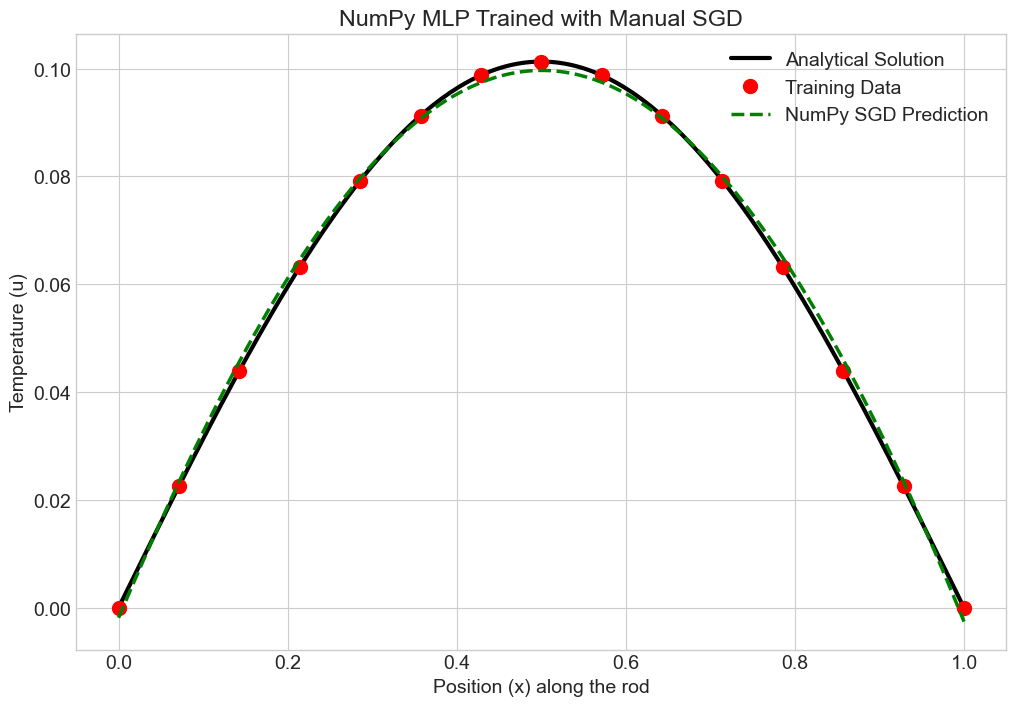

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Set up plot styles
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'font.size': 14, 'figure.figsize': (10, 6)})

# --- Set the random seed for reproducibility ---
seed = 42
np.random.seed(seed)

# -----------------------------------------------------------------------------
# 1. Generate Training Data
# -----------------------------------------------------------------------------
def analytical_solution(x):
    return (1 / (np.pi**2)) * np.sin(np.pi * x)

num_training_points = 15
x_train = np.linspace(0, 1, num_training_points, dtype=np.float32).reshape(-1, 1)
u_train = analytical_solution(x_train)

# -----------------------------------------------------------------------------
# 2. Define the Neural Network with Proper Initialization
# -----------------------------------------------------------------------------
class NonLinearMLP_NumPy:
    def __init__(self, input_size, hidden_size, output_size):
        # Glorot Initialization
        limit_w1 = np.sqrt(6 / (input_size + hidden_size))
        self.W1 = np.random.uniform(-limit_w1, limit_w1, (input_size, hidden_size)).astype(np.float32)
        self.b1 = np.zeros((1, hidden_size), dtype=np.float32)
        
        limit_w2 = np.sqrt(6 / (hidden_size + output_size))
        self.W2 = np.random.uniform(-limit_w2, limit_w2, (hidden_size, output_size)).astype(np.float32)
        self.b2 = np.zeros((1, output_size), dtype=np.float32)
        
        self.x = None
        self.z1 = None
        self.a1 = None

    def forward(self, x):
        self.x = x
        self.z1 = np.dot(x, self.W1) + self.b1
        self.a1 = np.tanh(self.z1)
        y_pred = np.dot(self.a1, self.W2) + self.b2
        return y_pred

# -----------------------------------------------------------------------------
# 3. Manual Training with SGD
# -----------------------------------------------------------------------------
def train_model_manual_sgd(model, x_data, y_data, epochs=50000, lr=0.1):
    n_samples = len(y_data)
    print(f"\n--- Training {model.__class__.__name__} with Manual SGD ---")

    for epoch in range(epochs):
        y_pred = model.forward(x_data)
        loss = np.mean((y_pred - y_data)**2)
        
        # Backpropagation to get gradients
        grad_y_pred = 2 * (y_pred - y_data) / n_samples
        grad_W2 = np.dot(model.a1.T, grad_y_pred)
        grad_b2 = np.sum(grad_y_pred, axis=0, keepdims=True)
        grad_a1 = np.dot(grad_y_pred, model.W2.T)
        grad_z1 = grad_a1 * (1 - np.tanh(model.z1)**2)
        grad_W1 = np.dot(model.x.T, grad_z1)
        grad_b1 = np.sum(grad_z1, axis=0, keepdims=True)
        
        # --- The key change: Simple Gradient Descent update rule ---
        model.W1 -= lr * grad_W1
        model.b1 -= lr * grad_b1
        model.W2 -= lr * grad_W2
        model.b2 -= lr * grad_b2
        
        if (epoch + 1) % 5000 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss:.8f}')
    print("Training complete.")
    return model

# Instantiate and train the model
numpy_model_sgd = NonLinearMLP_NumPy(input_size=1, hidden_size=32, output_size=1)
train_model_manual_sgd(numpy_model_sgd, x_train, u_train)

# -----------------------------------------------------------------------------
# 4. Visualize the Results
# -----------------------------------------------------------------------------
x_plot = np.linspace(0, 1, 200, dtype=np.float32).reshape(-1, 1)
u_pred_numpy = numpy_model_sgd.forward(x_plot)
u_true_plot = analytical_solution(x_plot)

plt.figure(figsize=(12, 8))
plt.title("NumPy MLP Trained with Manual SGD")
plt.xlabel("Position (x) along the rod")
plt.ylabel("Temperature (u)")
plt.plot(x_plot, u_true_plot, 'k-', label='Analytical Solution', linewidth=3)
plt.plot(x_train, u_train, 'ro', label='Training Data', markersize=10)
plt.plot(x_plot, u_pred_numpy, 'g--', label='NumPy SGD Prediction', linewidth=2.5)
plt.legend(loc='best')
plt.show()

Generated 15 training data points.

--- Training MLP with PyTorch SGD (lr=0.1) ---
Epoch [5000/50000], Loss: 0.00007349
Epoch [10000/50000], Loss: 0.00000442
Epoch [15000/50000], Loss: 0.00000363
Epoch [20000/50000], Loss: 0.00000345
Epoch [25000/50000], Loss: 0.00000328
Epoch [30000/50000], Loss: 0.00000312
Epoch [35000/50000], Loss: 0.00000298
Epoch [40000/50000], Loss: 0.00000284
Epoch [45000/50000], Loss: 0.00000272
Epoch [50000/50000], Loss: 0.00000261
Training complete.


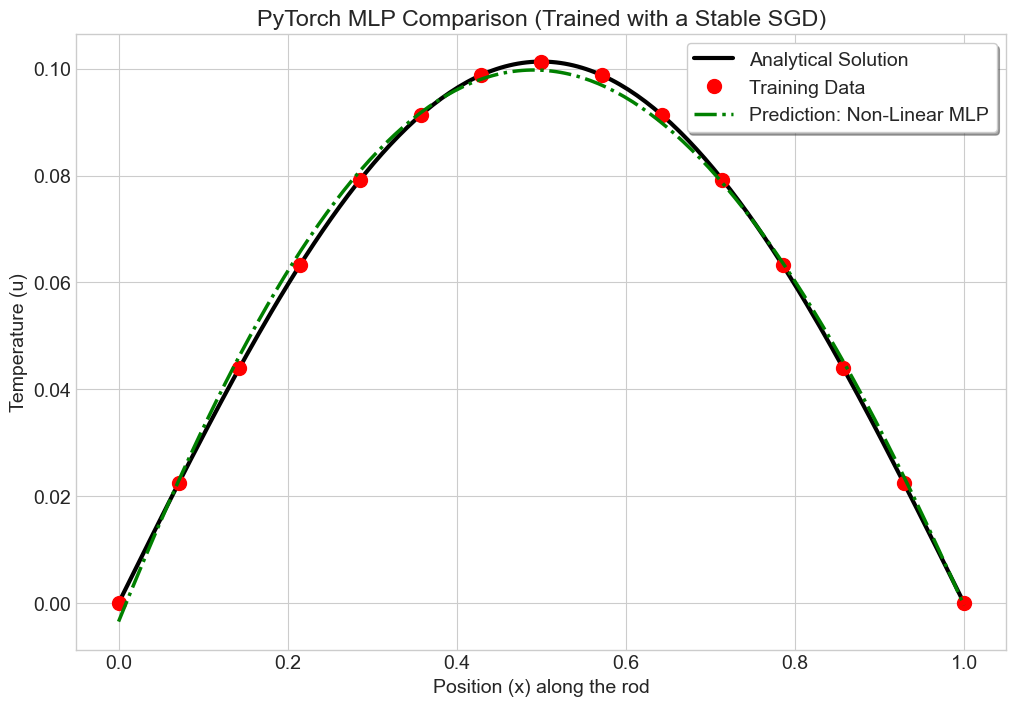

In [17]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Set up plot styles
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'font.size': 14, 'figure.figsize': (12, 8)})

# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# -----------------------------------------------------------------------------
# 1. Generate Training Data
# -----------------------------------------------------------------------------
def analytical_solution(x):
    return (1 / (np.pi**2)) * np.sin(np.pi * x)

num_training_points = 15
x_train = torch.linspace(0, 1, num_training_points, dtype=torch.float32).view(-1, 1)
u_train = torch.tensor(analytical_solution(x_train.numpy()), dtype=torch.float32)

print(f"Generated {num_training_points} training data points.")

# -----------------------------------------------------------------------------
# 2. Define the Neural Network Models
# -----------------------------------------------------------------------------
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.hidden = nn.Linear(1, 32)
        self.activation = nn.Tanh()
        self.output = nn.Linear(32, 1)

    def forward(self, x):
        x = self.hidden(x)
        x = self.activation(x)
        x = self.output(x)
        return x

# -----------------------------------------------------------------------------
# 3. Training Function
# -----------------------------------------------------------------------------
def train_model(model, x_data, y_data, epochs=50000, lr=0.1):
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    print(f"\n--- Training {model.__class__.__name__} with PyTorch SGD (lr={lr}) ---")
    for epoch in range(epochs):
        predictions = model(x_data)
        loss = criterion(predictions, y_data)
        
        # Check for nan loss to stop early
        if torch.isnan(loss):
            print(f"Loss is NaN at epoch {epoch}. Stopping training.")
            break
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 5000 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.8f}')
    print("Training complete.")
    return model

# Instantiate and train both models with the corrected learning rate
torch.manual_seed(seed)
nonlinear_model = MLP()
train_model(nonlinear_model, x_train, u_train)

# -----------------------------------------------------------------------------
# 4. Visualize and Compare the Results
# -----------------------------------------------------------------------------
x_plot = torch.linspace(0, 1, 200, dtype=torch.float32).view(-1, 1)

with torch.no_grad():
    u_pred_nonlinear = nonlinear_model(x_plot)

u_true_plot = analytical_solution(x_plot.numpy())

plt.figure(figsize=(12, 8))
plt.title("PyTorch MLP Comparison (Trained with a Stable SGD)")
plt.xlabel("Position (x) along the rod")
plt.ylabel("Temperature (u)")
plt.plot(x_plot.numpy(), u_true_plot, 'k-', label='Analytical Solution', linewidth=3)
plt.plot(x_train.numpy(), u_train.numpy(), 'ro', label='Training Data', markersize=10)
plt.plot(x_plot.numpy(), u_pred_nonlinear.numpy(), 'g-.', label='Prediction: Non-Linear MLP', linewidth=2.5)
plt.legend(loc='best', frameon=True, shadow=True)
plt.show()

In [1]:
%%html
<!DOCTYPE html>
<html>
<head>
<meta charset="utf-8">
<title>Interactive Neural Net Transformation</title>
<!-- 1. Load Plotly.js from a CDN -->
<script src="https://cdn.plot.ly/plotly-latest.min.js"></script>

<!-- 2. CSS for Styling the Application -->
<style>
    #interactive-nn-container { 
        font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, 'Helvetica Neue', Arial, sans-serif; 
        margin: 10px; 
        background-color: #f9f9f9; 
        padding: 15px;
        border: 1px solid #ccc;
        border-radius: 8px;
    }
    .nn-container { 
        display: grid; 
        grid-template-columns: repeat(auto-fit, minmax(350px, 1fr)); 
        gap: 20px; 
    }
    .nn-plot-container { 
        border: 1px solid #ddd; 
        border-radius: 8px; 
        background-color: #fff; 
        box-shadow: 0 2px 5px rgba(0,0,0,0.1); 
        padding: 10px;
    }
    .nn-controls { 
        grid-column: 1 / -1; 
        padding: 20px; 
        background-color: #fff; 
        border-radius: 8px; 
        border: 1px solid #ddd; 
        display: flex; 
        flex-wrap: wrap; 
        justify-content: space-around; 
        align-items: center; 
        gap: 20px; 
        margin-bottom: 20px;
    }
    .nn-slider-group { 
        display: flex; 
        flex-direction: column; 
        align-items: center; 
    }
    .nn-slider-group label { 
        font-weight: bold; 
        margin-bottom: 10px; 
        color: #333; 
    }
    .nn-slider-group input[type=range] { 
        width: 220px; 
    }
    .nn-solve-button { 
        padding: 10px 20px; 
        font-size: 16px; 
        font-weight: bold; 
        color: white; 
        background-color: #28a745; 
        border: none; 
        border-radius: 5px; 
        cursor: pointer; 
        transition: background-color 0.2s; 
    }
    .nn-solve-button:hover { 
        background-color: #218838; 
    }
    .nn-plot-title { 
        text-align: center; 
        font-size: 16px; 
        font-weight: bold; 
        padding-top: 15px; 
        color: #444; 
    }
    #nn-statusMessage { 
        grid-column: 1 / -1; 
        text-align: center; 
        font-size: 18px; 
        color: #007bff; 
        font-weight: bold; 
        min-height: 25px; 
    }
</style>
</head>
<body>

<div id="interactive-nn-container">
    <h2>Interactive Transformation Demo</h2>
    <p>Adjust the sliders to see how a linear (rotation + scaling) and non-linear (ReLU) transformation can make data separable. Or, press "Solve" to see a working solution.</p>

    <!-- 3. HTML Layout for Controls and Plots -->
    <div class="nn-controls">
        <div class="nn-slider-group">
            <label for="nn-rotationSlider">Rotation Angle: <span id="nn-rotationValue">0</span>°</label>
            <input type="range" id="nn-rotationSlider" min="-180" max="180" value="0" step="1">
        </div>
        <div class="nn-slider-group">
            <label for="nn-scaleSlider">Scaling Factor: <span id="nn-scaleValue">1.00</span></label>
            <input type="range" id="nn-scaleSlider" min="0.5" max="3" value="1.0" step="0.05">
        </div>
        <div class="nn-slider-group">
            <label for="nn-reluSlider">ReLU Negative Slope: <span id="nn-reluValue">0.00</span></label>
            <input type="range" id="nn-reluSlider" min="0" max="1" value="1.0" step="0.01">
        </div>
        <button id="nn-solveButton" class="nn-solve-button">Solve</button>
    </div>

    <div id="nn-statusMessage"></div>

    <div class="nn-container">
        <div class="nn-plot-container">
            <div class="nn-plot-title">1. Original Data (Input Space X)</div>
            <div id="nn-plotX"></div>
        </div>
        <div class="nn-plot-container">
            <div class="nn-plot-title">2. After Linear Transform (Y = WX)</div>
            <div id="nn-plotY"></div>
        </div>
        <div class="nn-plot-container">
            <div class="nn-plot-title">3. After Non-linearity (Z = f(Y))</div>
            <div id="nn-plotZ"></div>
        </div>
    </div>
</div>

<!-- 4. JavaScript for Interactivity -->
<script>
    (function() {
        // --- DATA DEFINITION ---
        const class0_X = [
            [-2.75, 0.27], [-3.63, 1.20], [-2.51, 1.95], [-1.85, 3.12], [-0.81, 2.54], [0.03, 3.58], 
            [1.82, 3.23], [3.37, 2.48], [4.76, 1.96], [4.74, 0.82], [3.22, 1.02], [0.38, 1.22],
            [-0.62, -0.04], [0.52, -0.44], [1.72, -0.31], [2.29, -1.63], [0.87, -1.84], [-0.87, -1.52]
        ];
        const class1_X = [
            [-5.33, 2.15], [-4.88, 3.79], [-3.99, 3.16], [-2.98, 4.30], [-1.91, 6.07], [-1.06, 4.89], 
            [0.78, 5.01], [-0.22, 6.47], [1.43, 6.11], [2.98, 4.41], [4.50, 3.61], [5.13, 4.95], [6.37, 3.01]
        ];

        // --- PLOTTING SETUP ---
        const plotLayout = {
            margin: { l: 40, r: 20, t: 20, b: 40 },
            xaxis: { range: [-15, 15], zeroline: true, zerolinewidth: 2, zerolinecolor: '#ddd' },
            yaxis: { range: [-15, 15], zeroline: true, zerolinewidth: 2, zerolinecolor: '#ddd', scaleanchor: "x", scaleratio: 1 },
            showlegend: false,
            autosize: true
        };
        const traceClass0 = { mode: 'markers', type: 'scatter', marker: { color: 'magenta', size: 8, line: { color: 'purple', width: 1.5 } } };
        const traceClass1 = { mode: 'markers', type: 'scatter', marker: { color: 'gold', size: 8, line: { color: 'orange', width: 1.5 } } };
        const unpack = (points) => ({ x: points.map(p => p[0]), y: points.map(p => p[1]) });

        // --- TRANSFORMATION LOGIC ---
        function linearTransform(points, angleDeg, scale) {
            const angleRad = angleDeg * Math.PI / 180;
            const cosT = Math.cos(angleRad);
            const sinT = Math.sin(angleRad);
            return points.map(p => {
                const rotX = p[0] * cosT - p[1] * sinT;
                const rotY = p[0] * sinT + p[1] * cosT;
                return [rotX * scale, rotY * scale];
            });
        }

        function nonlinearTransform(points, slope) {
            return points.map(p => [p[0] > 0 ? p[0] : p[0] * slope, p[1] > 0 ? p[1] : p[1] * slope]);
        }

        // --- MAIN UPDATE FUNCTION ---
        function updatePlots(isSolve = false) {
            const angle = parseFloat(document.getElementById('nn-rotationSlider').value);
            const scale = parseFloat(document.getElementById('nn-scaleSlider').value);
            const slope = parseFloat(document.getElementById('nn-reluSlider').value);
            
            document.getElementById('nn-rotationValue').textContent = angle.toFixed(0);
            document.getElementById('nn-scaleValue').textContent = scale.toFixed(2);
            document.getElementById('nn-reluValue').textContent = slope.toFixed(2);

            const class0_Y = linearTransform(class0_X, angle, scale);
            const class1_Y = linearTransform(class1_X, angle, scale);
            const class0_Z = nonlinearTransform(class0_Y, slope);
            const class1_Z = nonlinearTransform(class1_Y, slope);

            Plotly.react('nn-plotY', [{ ...traceClass0, ...unpack(class0_Y) }, { ...traceClass1, ...unpack(class1_Y) }], plotLayout);
            
            const plotZ_data = [{ ...traceClass0, ...unpack(class0_Z) }, { ...traceClass1, ...unpack(class1_Z) }];
            
            if (isSolve) {
                // --- MODIFIED SECTION: Create a scaled diagonal line ---
                const line_p1_base = [0, 5];
                const line_p2_base = [4.7, 0];

                // Scale the line's endpoints by the current scaling factor
                const line_p1_scaled = [line_p1_base[0] * scale, line_p1_base[1] * scale];
                const line_p2_scaled = [line_p2_base[0] * scale, line_p2_base[1] * scale];

                const separatingLine = {
                    x: [line_p1_scaled[0], line_p2_scaled[0]],
                    y: [line_p1_scaled[1], line_p2_scaled[1]],
                    mode: 'lines',
                    type: 'scatter',
                    line: { color: 'blue', width: 3, dash: 'dash' }
                };
                // --- END OF MODIFIED SECTION ---

                plotZ_data.push(separatingLine);
                document.getElementById('nn-statusMessage').textContent = 'Solved! The data is now linearly separable.';
            } else {
                document.getElementById('nn-statusMessage').textContent = '';
            }
            
            Plotly.react('nn-plotZ', plotZ_data, plotLayout);
        }

        // --- SOLVE FUNCTION ---
        function solve() {
            const optimalAngle = -59;
            const optimalScale = 2.0;
            const optimalSlope = 0.0;

            document.getElementById('nn-rotationSlider').value = optimalAngle;
            document.getElementById('nn-scaleSlider').value = optimalScale;
            document.getElementById('nn-reluSlider').value = optimalSlope;
            
            updatePlots(true);
        }

        // --- INITIALIZATION ---
        function init() {
            Plotly.newPlot('nn-plotX', [{ ...traceClass0, ...unpack(class0_X) }, { ...traceClass1, ...unpack(class1_X) }], plotLayout);
            
            document.getElementById('nn-rotationSlider').addEventListener('input', () => updatePlots(false));
            document.getElementById('nn-scaleSlider').addEventListener('input', () => updatePlots(false));
            document.getElementById('nn-reluSlider').addEventListener('input', () => updatePlots(false));
            document.getElementById('nn-solveButton').addEventListener('click', solve);
            
            window.addEventListener('resize', () => {
                Plotly.relayout('nn-plotX', { 'width': document.getElementById('nn-plotX').parentElement.clientWidth - 20 });
                Plotly.relayout('nn-plotY', { 'width': document.getElementById('nn-plotY').parentElement.clientWidth - 20 });
                Plotly.relayout('nn-plotZ', { 'width': document.getElementById('nn-plotZ').parentElement.clientWidth - 20 });
            });

            updatePlots(false);
        }

        if (document.readyState === 'loading') {
            document.addEventListener('DOMContentLoaded', init);
        } else {
            init();
        }
    })();
</script>

</body>
</html>